In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.models import Model

pngs_dir = "/content/drive/MyDrive/ENEE439D Group Project/Cloud Data /PNGs"

images = []
for filename in sorted(os.listdir(pngs_dir)):
    if filename.find("Masked") >= 0:
        img_path = os.path.join(pngs_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (640, 320))
        images.append(img)

images = np.array(images)
images = np.expand_dims(images, axis=-1)
images = images.astype('float32') / 255.0  # Normalization

def create_shifted_frames(images, sequence_length=10):
    x, y = [], []
    for i in range(len(images) - sequence_length):
        x.append(images[i:i + sequence_length])
        y.append(images[i + 1:i + sequence_length + 1])
    return np.array(x), np.array(y)

x, y = create_shifted_frames(images)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

def build_model():
    input_img = Input(shape=(None, 320, 640, 1))
    model = tf.keras.Sequential([
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=(None, 64, 64, 1)),
        ConvLSTM2D(64, (3, 3), return_sequences=True, padding='same'),
        BatchNormalization(),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
model.summary()

model.fit(x_train, y_train, epochs=20, batch_size=2, validation_data=(x_val, y_val))

def predict_sequence(model, start_frame, end_frame, num_intermediate_frames):
    # Create a batch with the start and end frames
    input_frames = np.stack([start_frame, end_frame], axis=0)
    input_frames = np.expand_dims(input_frames, axis=0)
    predictions = model.predict(input_frames)

    return predictions[0]

# Test
start_frame = x_val[0][0]
end_frame = x_val[0][-1]
predicted_frames = predict_sequence(model, start_frame, end_frame, 10)


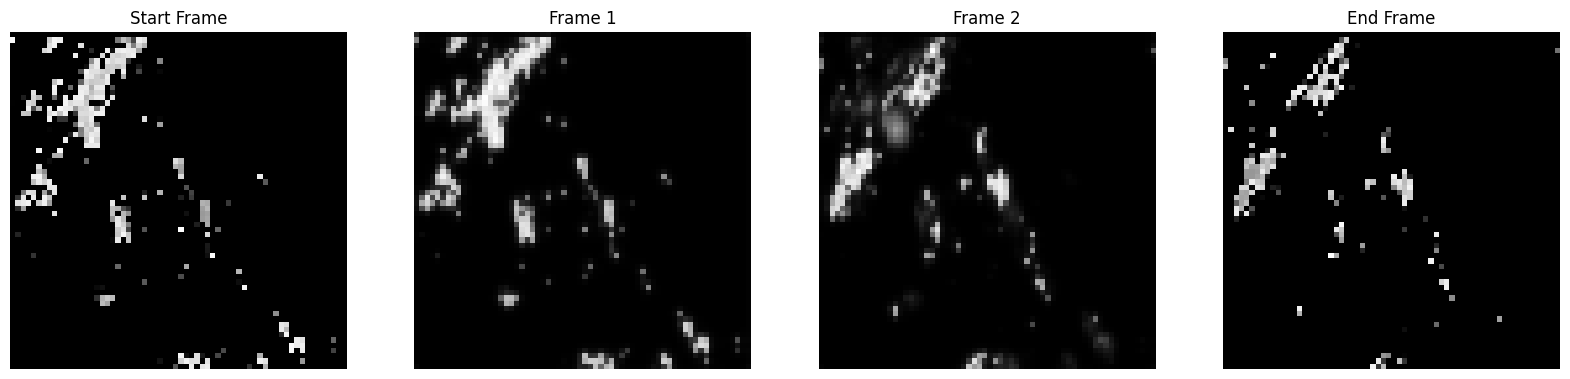

In [ ]:
import matplotlib.pyplot as plt

def interpolate_frames(model, start_frame, end_frame, num_intermediate_frames):
    start_frame = start_frame / 255.0
    end_frame = end_frame / 255.0
    input_frames = np.stack([start_frame, end_frame], axis=0)
    input_frames = np.expand_dims(input_frames, axis=0)
    interpolated_frames = [start_frame
    for _ in range(num_intermediate_frames):
        prediction = model.predict(input_frames)[0, -1:, :, :, :]
        interpolated_frames.append(prediction.squeeze())
        input_frames = np.concatenate((input_frames[:, 1:, :, :, :], np.expand_dims(prediction, axis=1)), axis=1)
    # Add end frame to sequence
    interpolated_frames.append(end_frame)
    return np.array(interpolated_frames)

def visualize_frames(frames):
    num_frames = len(frames)
    fig, axes = plt.subplots(1, num_frames, figsize=(2 * num_frames, 5))

    for i, frame in enumerate(frames):
        if len(axes) > 1:
            ax = axes[i]
        else:
            ax = axes

        ax.imshow(frame.squeeze(), cmap='gray')
        ax.set_title(f"Frame {i+1}")
        ax.axis('off')

    plt.show()

start_frame = x_val[0][0] * 255.0
end_frame = x_val[0][-1] * 255.0
num_intermediate_frames = 10
frames = interpolate_frames(model, start_frame, end_frame, num_intermediate_frames)

visualize_frames(frames)